## Execise 1 mlflow

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

In [167]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import subprocess
import time
import IPython.display as display
import tempfile

In [168]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Jlo\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [169]:
dataset_path = path

files = os.listdir(dataset_path)
print(files)

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [170]:
file_path = path + "/PJME_hourly.csv"

In [171]:
df = pd.read_csv(file_path)

In [172]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


Based on the data, we see that the target variable, PJME_MW, is a continuous numeric value representing energy consumption. This confirms that we have a regression problem, so we'll use regression models.

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
#df = df.sample(5000)
df = df.sort_index()

In [174]:
# Now, perform feature engineering on the filtered dataset only:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['year'] = df.index.year


# Verify that the new features have been added
print("Columns in filtered data:", df.columns)
print(df.head())

Columns in filtered data: Index(['PJME_MW', 'hour', 'day', 'month', 'dayofweek', 'year'], dtype='object')
                     PJME_MW  hour  day  month  dayofweek  year
Datetime                                                       
2004-03-28 16:00:00  25349.0    16   28      3          6  2004
2018-04-05 06:00:00  29625.0     6    5      4          3  2018
2004-01-16 16:00:00  40144.0    16   16      1          4  2004
2010-02-04 02:00:00  29616.0     2    4      2          3  2010
2010-09-29 07:00:00  28859.0     7   29      9          2  2010


In [185]:
df.describe()

,PJME_MW,hour,day,month,dayofweek,year
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,32255.599800,11.515000,15.700200,6.514000,2.952800,2009.789800
std,6432.306542,6.871275,8.798534,3.456905,1.986495,4.785039
min,14955.000000,0.000000,1.000000,1.000000,0.000000,2002.000000
25%,27799.750000,6.000000,8.000000,3.000000,1.000000,2006.000000
50%,31636.500000,11.000000,16.000000,7.000000,3.000000,2010.000000
75%,35788.750000,17.000000,23.000000,9.000000,5.000000,2014.000000
max,58686.000000,23.000000,31.000000,12.000000,6.000000,2018.000000


Define targets and features

In [175]:
TARGET = 'PJME_MW'
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [176]:
print(y.head())

Datetime
2004-03-28 16:00:00    25349.0
2018-04-05 06:00:00    29625.0
2004-01-16 16:00:00    40144.0
2010-02-04 02:00:00    29616.0
2010-09-29 07:00:00    28859.0
Name: PJME_MW, dtype: float64


In [177]:
train_size = int(0.8 * len(df))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
feature_combinations = [
    ['hour', 'day', 'month'],
    ['hour', 'day', 'month', 'dayofweek'],
    ['hour', 'month', 'dayofweek', 'year']
]

In [179]:
print("Feature combos:", feature_combinations)

Feature combos: [['hour', 'day', 'month'], ['hour', 'day', 'month', 'dayofweek'], ['hour', 'month', 'dayofweek', 'year']]


The mlflow was really slow, so lets try to convert to numpy array

In [180]:
X_train_np = {}
X_test_np = {}

for combo in feature_combinations:
    key = "_".join(combo)  # Create a key based on the feature names
    X_train_np[key] = X_train[combo].values
    X_test_np[key] = X_test[combo].values

# Example: Check shapes for the first feature combination
print("Example for combo1 (", feature_combinations[0], "):")
print("X_train_np:", X_train_np["_".join(feature_combinations[0])].shape)
print("X_test_np:", X_test_np["_".join(feature_combinations[0])].shape)

Example for combo1 ( ['hour', 'day', 'month'] ):
X_train_np: (4000, 3)
X_test_np: (1000, 3)


In [ ]:
# Define hyperparameter options for each regression model
hyperparams = {
    'RandomForestRegressor': [
         {'n_estimators': 20, 'max_depth': 3, 'min_samples_split': 2},
         {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 4},
         {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4}
    ],
    'LinearRegression': [
         {},  # No hyperparameters, but we include three "options" to satisfy requirements
         {},
         {}
    ],
    'KNeighborsRegressor': [
         {'n_neighbors': 6},
         {'n_neighbors': 10},
         {'n_neighbors': 15}
    ]
}

defining time splits 

In [ ]:
time_splits = [
    ('2002-01-01', '2010-12-31'),
    ('2002-01-01', '2013-12-31'),
    ('2002-01-01', '2016-12-31')
]


Training models with features: ['hour', 'day', 'month']


2025/03/16 01:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:36:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:36:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:08 


Training models with features: ['hour', 'day', 'month', 'dayofweek']


2025/03/16 01:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:37:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:38:01 


Training models with features: ['hour', 'month', 'dayofweek', 'year']


2025/03/16 01:38:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/16 01:38:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\Jlo\AppData\Local\Temp\ipykernel_20340\624154.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 4))
2025/03/16 01:38:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu


Summary of Experiment Results:
                          features                  model         RMSE  \
0               [hour, day, month]  RandomForestRegressor  4231.317280   
1               [hour, day, month]  RandomForestRegressor  4119.919573   
2               [hour, day, month]  RandomForestRegressor  3880.709113   
3               [hour, day, month]       LinearRegression  5789.094116   
4               [hour, day, month]       LinearRegression  5789.094116   
5               [hour, day, month]       LinearRegression  5789.094116   
6               [hour, day, month]    KNeighborsRegressor  4160.138960   
7               [hour, day, month]    KNeighborsRegressor  4079.470999   
8               [hour, day, month]    KNeighborsRegressor  4102.601765   
9    [hour, day, month, dayofweek]  RandomForestRegressor  3597.374841   
10   [hour, day, month, dayofweek]  RandomForestRegressor  3911.913497   
11   [hour, day, month, dayofweek]  RandomForestRegressor  3413.157643   
12   [

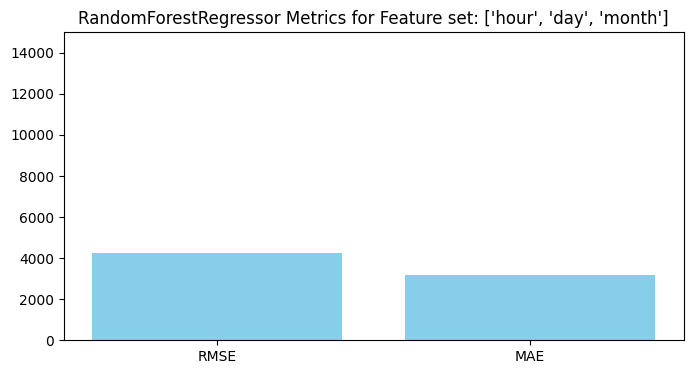

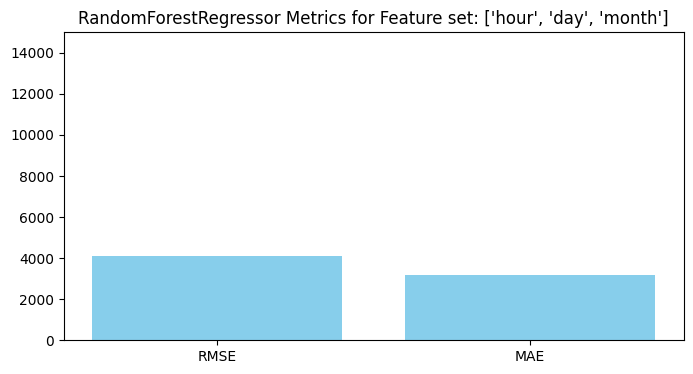

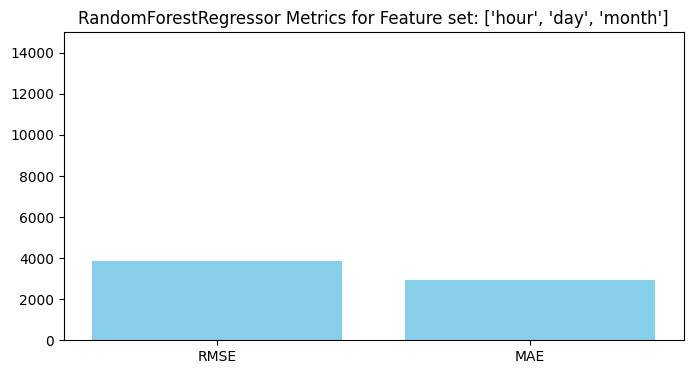

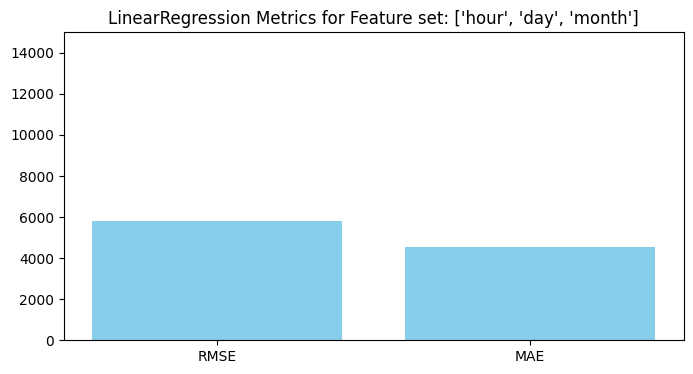

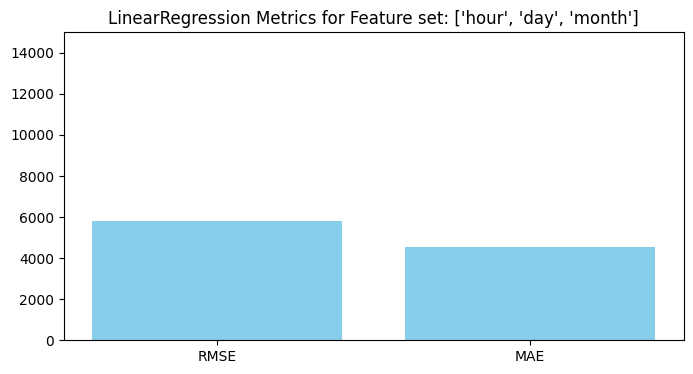

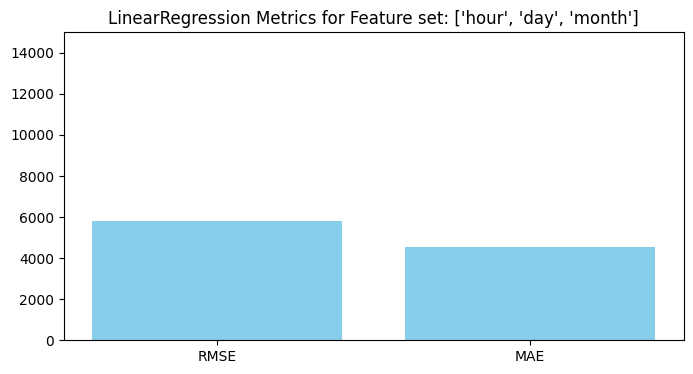

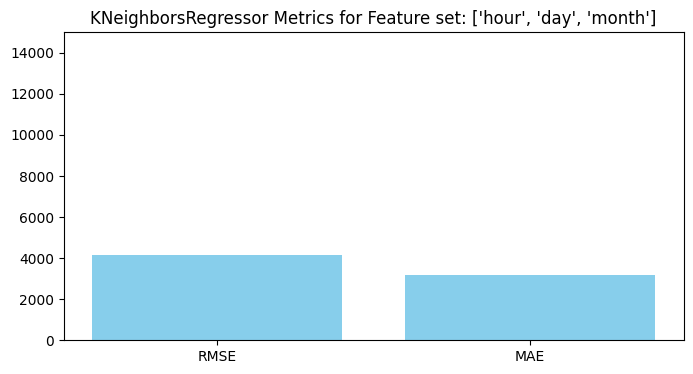

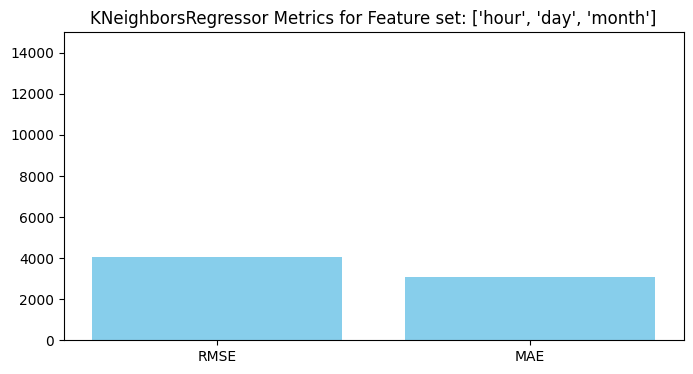

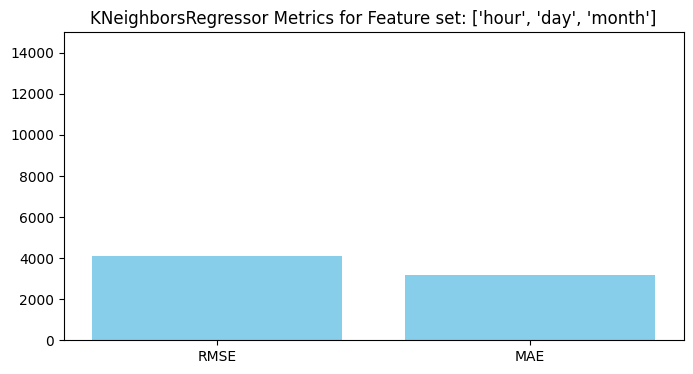

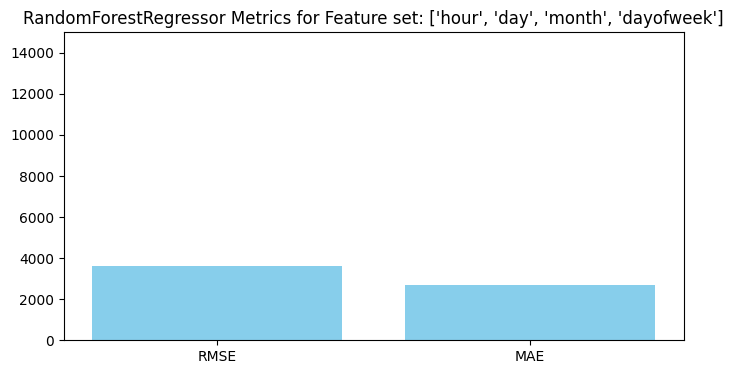

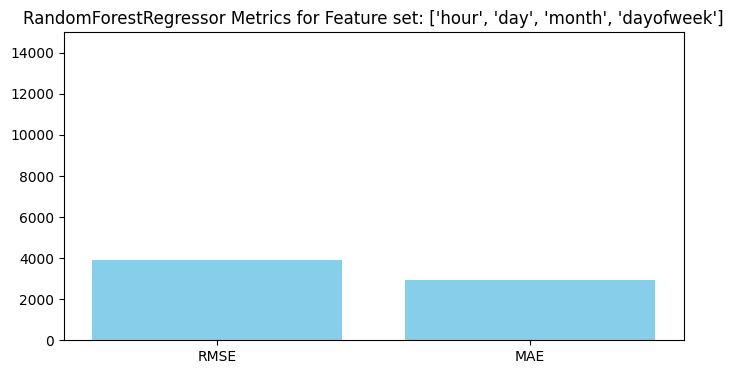

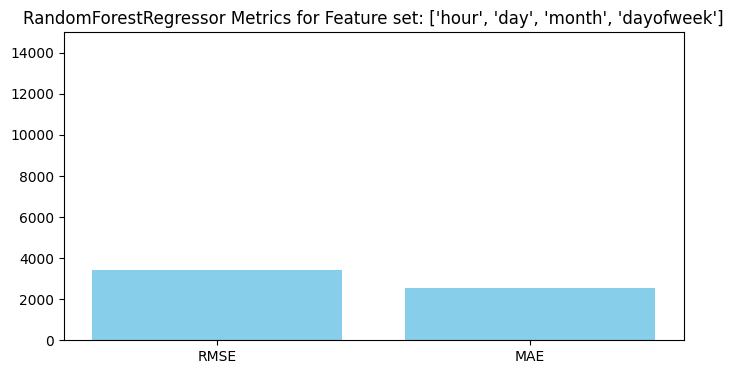

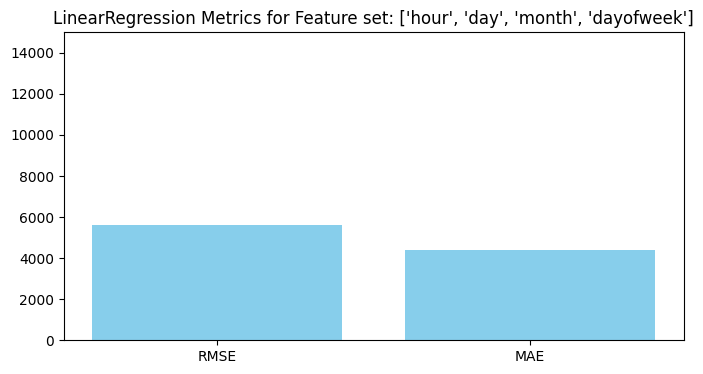

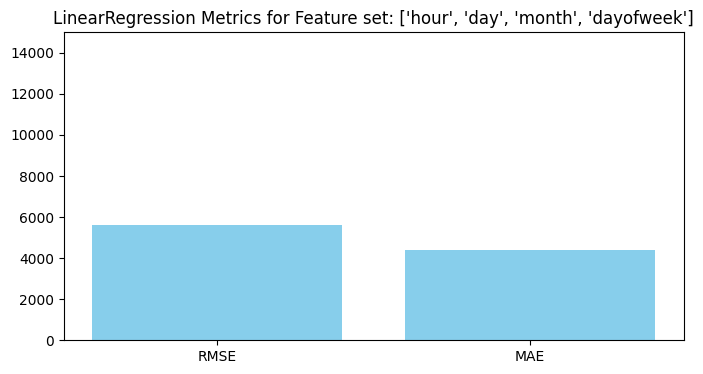

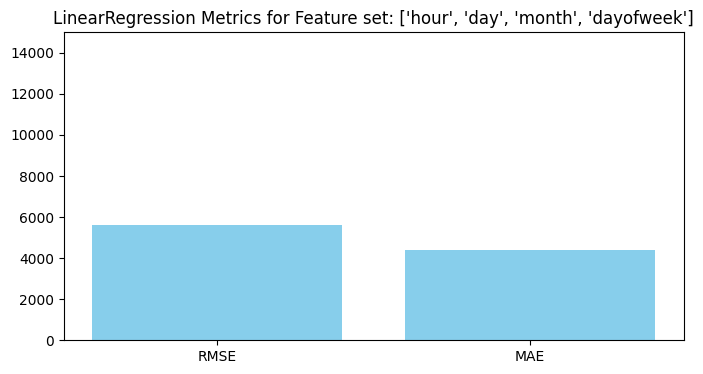

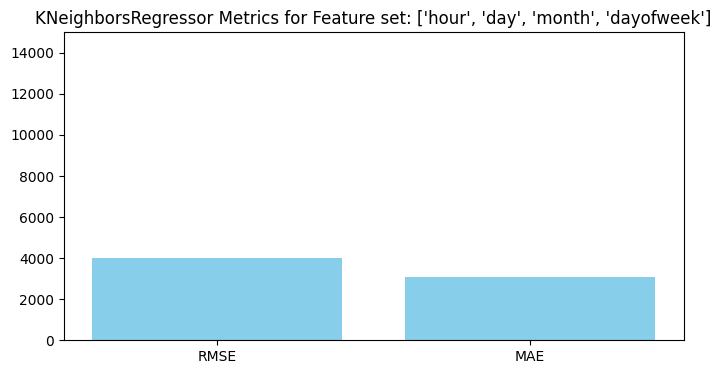

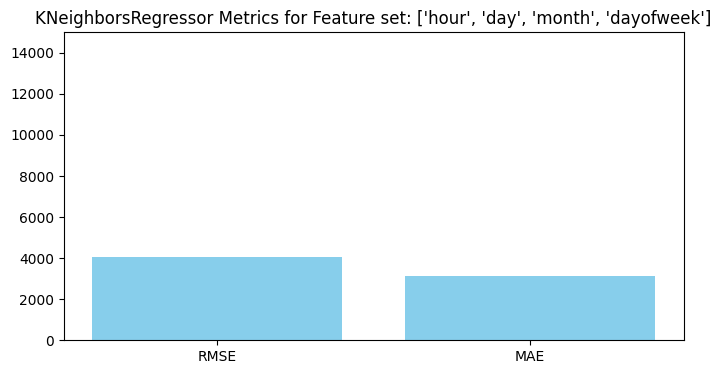

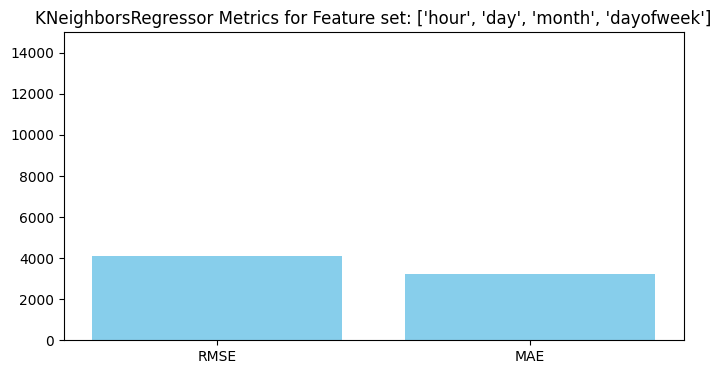

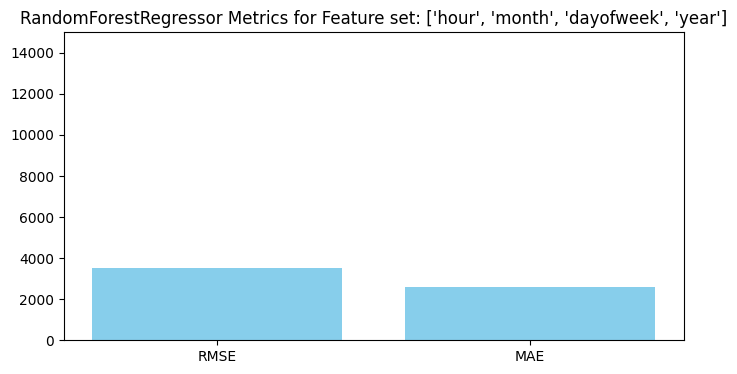

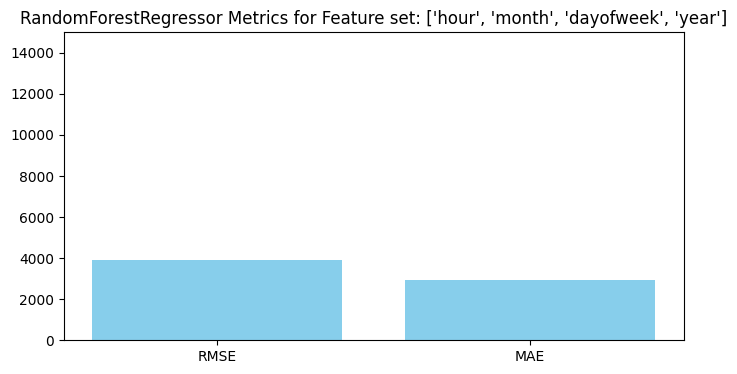

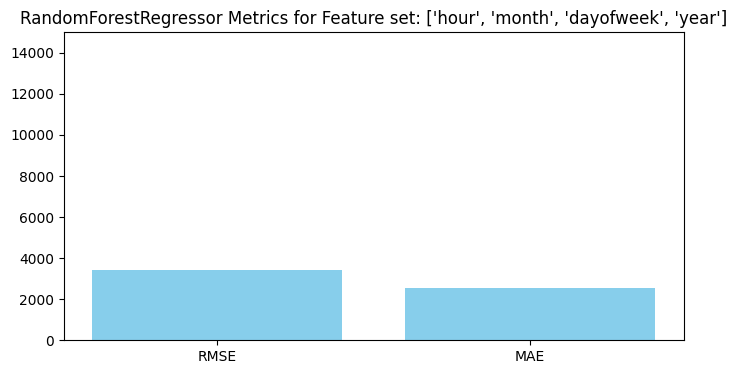

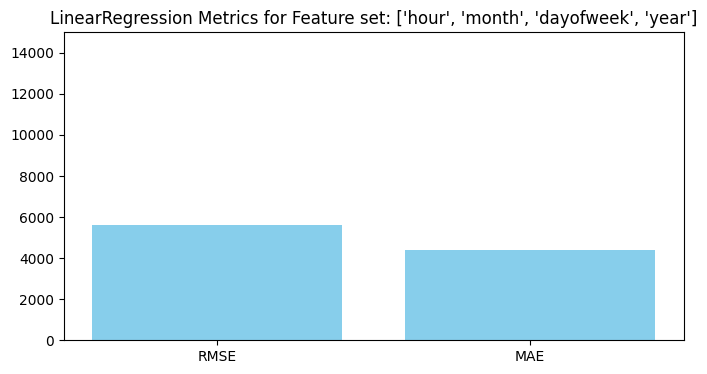

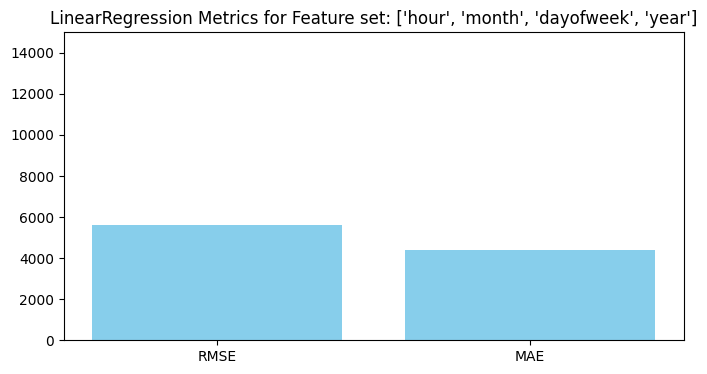

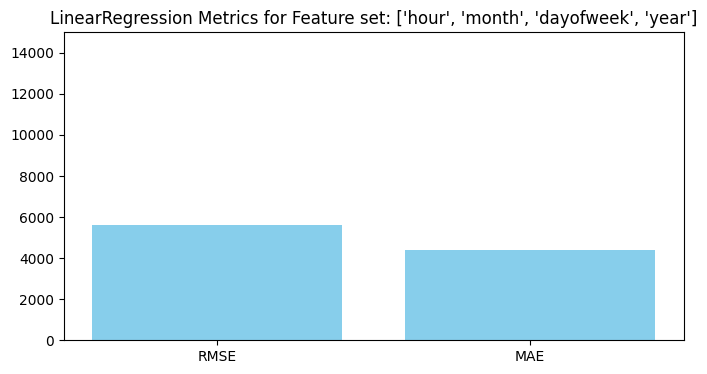

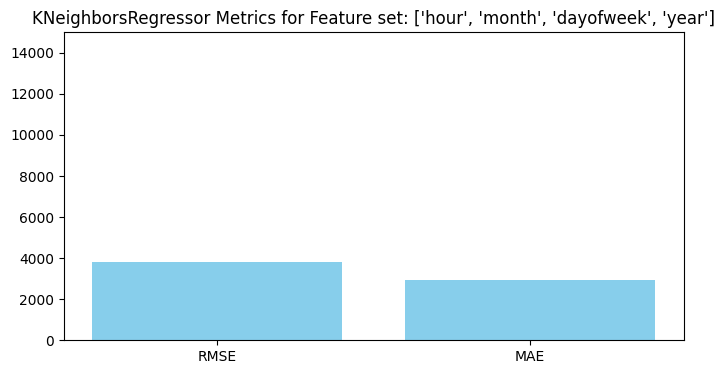

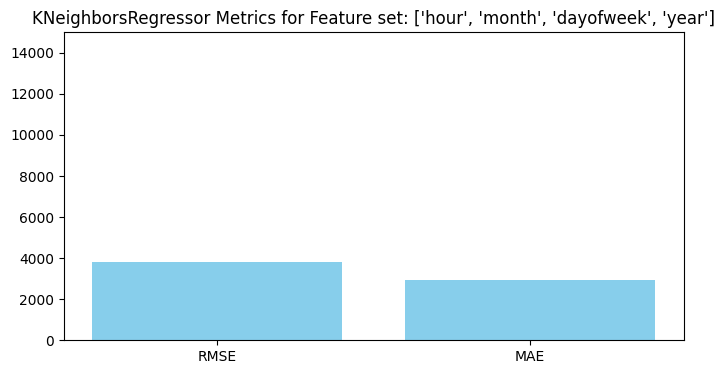

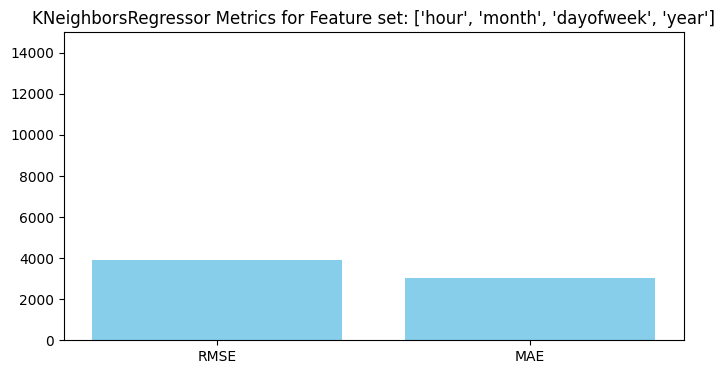

In [ ]:
mlflow.set_experiment("energy_consumption")

results = []

for features in feature_combinations:
        key = "_".join(features)
        for model_name in ['RandomForestRegressor','LinearRegression','KNeighborsRegressor']:
            for hyperparam in hyperparams[model_name]:
                for split in time_splits:
                    print(f"\nTraining {model_name} with hyperparams {hyperparam} on data up to {split[1]}")
                    train_start, train_end = split
                    df_train_split = df.loc[train_start:train_end]
                    df_test_split = df.loc[train_end:]
                    if df_train_split.empty or df_test_split.empty:
                        continue
                    X_train_split = df_train_split[features]
                    y_train_split = df_train_split[TARGET]
                    X_test_split = df_test_split[features]
                    y_test_split = df_test_split[TARGET]
                    
                    X_train_split_np = X_train_split.values
                    X_test_split_np = X_test_split.values
                    with mlflow.start_run(nested=True):
                        # Log feature combination and model type
                        mlflow.log_param("features", features)
                        mlflow.log_param("model", model_name)
                        mlflow.log_param("hyperparameters", hyperparam)
                        mlflow.log_param("time_split", split)

                        # Create and train the model
                        if model_name == 'RandomForestRegressor':
                            model = RandomForestRegressor(**hyperparam, random_state=42)
                        elif model_name == 'LinearRegression':
                            model = LinearRegression(**hyperparam)
                        elif model_name == 'KNeighborsRegressor':
                            model = KNeighborsRegressor(**hyperparam)
                        
                        model.fit(X_train_split_np, y_train_split)
                        predictions = model.predict(X_test_split_np)

                        #calculate metrics
                        rmse = root_mean_squared_error(y_test_split, predictions)
                        mae = mean_absolute_error(y_test_split, predictions)
                        mlflow.log_metric("RMSE", rmse)
                        mlflow.log_metric("MAE", mae)

                        # Create and log a plot for actual vs. predicted (1 month)
                        one_month = 24 * 30
                        y_test_month = y_test_split.iloc[:min(one_month, len(y_test_split))]
                        # Since predictions is a NumPy array aligned with y_test_split, we slice similarly:
                        y_pred_month = predictions[:min(one_month, len(predictions))]
                        fig, ax = plt.subplots(figsize=(10,6))
                        ax.plot(y_test_month.index, y_test_month, label="Actual")
                        ax.plot(y_test_month.index, y_pred_month, label="Predicted")
                        ax.set_title(f"Actual vs. Predicted - 1 Month ({model_name}, {features}, {split[1]})")
                        ax.legend()
                        temp_file_month = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                        plt.savefig(temp_file_month.name)
                        mlflow.log_artifact(temp_file_month.name, artifact_path="plots")
                        plt.close(fig)

                        # Create and log a plot for actual vs. predicted (1 week)
                        one_week = 24 * 7
                        y_test_week = y_test_split.iloc[:min(one_week, len(y_test_split))]
                        y_pred_week = predictions[:min(one_week, len(predictions))]
                        fig, ax = plt.subplots(figsize=(10,6))
                        ax.plot(y_test_week.index, y_test_week, label="Actual")
                        ax.plot(y_test_week.index, y_pred_week, label="Predicted")
                        ax.set_title(f"Actual vs. Predicted - 1 Week ({model_name}, {features}, {split[1]})")
                        ax.legend()
                        temp_file_week = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                        plt.savefig(temp_file_week.name)
                        mlflow.log_artifact(temp_file_week.name, artifact_path="plots")
                        plt.close(fig)
                        
                        # Create and log a plot of the metrics
                        fig, ax = plt.subplots(figsize=(8, 4))
                        metrics = [rmse, mae]
                        metric_names = ['RMSE', 'MAE']
                        ax.bar(metric_names, metrics, color="skyblue")
                        ax.set_title(f"{model_name} Metrics for Feature set: {features}")
                        ax.set_ylim(0, 15000)
                        # Save the plot to a temporary file and log it as an artifact
                        temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                        plt.savefig(temp_file.name)
                        mlflow.log_artifact(temp_file.name, artifact_path="plots")
                        temp_file.close()

                        # Log the model
                        mlflow.sklearn.log_model(model, model_name)
                    
                        # Store results for summary
                        results.append({
                            "features": features,
                            "model": model_name,
                            "time_split": split,
                            "hyperparameters": hyperparam,
                            "RMSE": rmse,
                            "MAE": mae
                        })
                        mlflow.end_run()
# Print summary of results
results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)


In [183]:
# Start MLFlow UI from the notebook
print("\nStarting MLFlow UI...")
process = subprocess.Popen(["python", "-m", "mlflow", "ui", "--port", "5000"])
# Wait a moment to ensure the server starts
time.sleep(3)

# Display a link to the MLFlow UI
display.display(display.Markdown("[Open MLFlow UI](http://localhost:5000)"))

print("MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.")


Starting MLFlow UI...


[Open MLFlow UI](http://localhost:5000)

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.


In [184]:
!mlflow ui

'mlflow' is not recognized as an internal or external command,
operable program or batch file.
